<a href="https://colab.research.google.com/github/Dharani578/FMML_COURSE/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-08 08:38:14--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.164.154.37, 18.164.154.17, 18.164.154.123, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.164.154.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   289MB/s    in 0.2s    

2024-05-08 08:38:14 (289 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


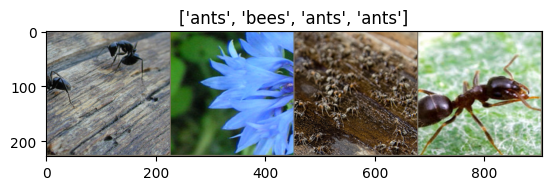

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.8086 Acc: 0.6311

Epoch 1/4
----------
Loss: 0.5264 Acc: 0.7705

Epoch 2/4
----------
Loss: 0.5055 Acc: 0.8074

Epoch 3/4
----------
Loss: 0.6935 Acc: 0.7500

Epoch 4/4
----------
Loss: 0.5249 Acc: 0.8197



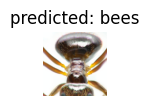

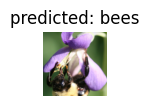

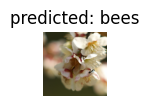

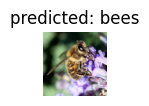

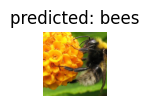

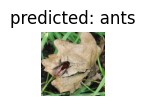

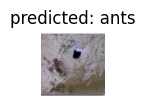

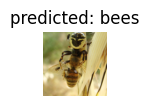

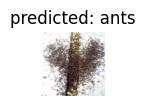

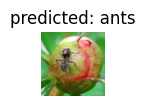

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


1 ANS


Data augmentation techniques like resizing, cropping, flipping, rotation, and color jittering are commonly used in training machine learning models, particularly in computer vision tasks. These techniques serve several significant purposes:

Increased Robustness: By applying random transformations to the training data, the model learns to become more robust to variations and distortions in the input data. This can help improve the generalization of the model, making it perform better on unseen data.
Increased Dataset Size: Data augmentation effectively increases the effective size of the training dataset without collecting additional data. This is particularly useful when working with limited datasets, as it helps prevent overfitting by exposing the model to more diverse examples.
Reduced Overfitting: Overfitting occurs when a model learns to memorize the training data rather than generalize from it. Data augmentation introduces variability into the training process, which can help prevent the model from overfitting to the training set.
Better Generalization: By exposing the model to various transformations of the input data during training, it learns to recognize the underlying patterns in different contexts. This typically leads to better generalization performance on unseen data, as the model becomes more invariant to certain changes in the input.
Improved Performance: In many cases, data augmentation techniques can lead to improved performance metrics such as accuracy, precision, recall, or F1 score, especially when applied judiciously in combination with other regularization techniques.
Realism: Data augmentation techniques often mimic real-world variations and distortions that can occur in the input data. By training on augmented data, the model becomes more adept at handling such variations, leading to more realistic and robust predictions in deployment scenarios.
In summary, data augmentation is a crucial strategy for enhancing the performance and robustness of machine learning models, particularly in tasks like image classification, object detection, and segmentation, where the input data may exhibit various forms of variability and distortion.








2 ANS


If you don't use a pre-trained ResNet model and instead train it from scratch, the performance may vary depending on factors such as the size and diversity of your dataset, the complexity of the task, and the hyperparameters chosen for training. Generally, training a deep neural network like ResNet from scratch on a small dataset might lead to overfitting due to the large number of parameters that need to be learned.

However, if you have a sufficiently large and diverse dataset and you train the model with appropriate regularization techniques, you might still achieve decent performance. It's important to use techniques like data augmentation, dropout, weight regularization, and early stopping to prevent overfitting when training from scratch.

Without specific details about the dataset and the task at hand, it's challenging to provide an exact performance estimate. Typically, training a deep neural network from scratch requires more computational resources and time compared to fine-tuning a pre-trained model. The performance you get will depend on how well you can balance model complexity, regularization, and optimization strategies during training.








3 ANS


Domain Similarity: If the pre-trained ResNet model was trained on a dataset that is significantly different from the ants vs bees dataset in terms of domain, content, or characteristics, then directly using this pre-trained model might not yield optimal performance. Pre-trained models are most effective when the pre-training data is similar to the target task data.
Transferability of Features: However, even if the pre-trained model was trained on a different dataset, the lower layers of the network might have learned general features like edges, textures, and basic shapes that are useful across various domains. In this case, fine-tuning the pre-trained model on the ants vs bees dataset by updating the weights of the higher layers while keeping the lower layers fixed or with a lower learning rate could still yield good performance.
Amount of Available Data: The amount of data available for fine-tuning also plays a crucial role. If the ants vs bees dataset is small, fine-tuning a pre-trained model might lead to overfitting. In such cases, it might be beneficial to use techniques like data augmentation, dropout, or transfer learning from a model trained on a more similar dataset.
Task Complexity: The complexity of the ants vs bees classification task also matters. If it's a relatively simple task, a pre-trained model might generalize well even from a dissimilar dataset. However, if the task is more complex or requires understanding domain-specific features, fine-tuning or re-training the model might be necessary.
In summary, while using a pre-trained ResNet model on a significantly different dataset may not guarantee good performance out-of-the-box, it can still provide a valuable starting point. Fine-tuning the pre-trained model or using transfer learning techniques while considering the factors mentioned above can help leverage the knowledge encoded in the pre-trained model and adapt it to the specific characteristics of the ants vs bees dataset.






